# Deel II. Deep learning

## Hoofdstuk 3. Neurale netwerken

1. [Inleiding](#Inleiding)
2. [Het multi-layer perceptron](#Het_multi_layer_perceptron)
3. [Initialisatie](#Initialisatie)
4. [Het *XOR*-probleem](#XOR_problem)
5. [Forward-propagation](#Forward_propagation)
6. [Losses](#Losses)
7. [Back-propagation](#Back_propagation)

### <a id='Inleiding'>Inleiding</a>

Dit is het Jupyter Notebook behorende bij hoofdstuk 3 van het vak *Advanced Datamining* (BFVH4DMN2). Op BlackBoard tref je eveneens een module `data.py` aan die diverse functies bevat die helpen bij het genereren en het visualiseren van de gebruikte datasets. Kopieer het bestand `model.py` van het vorige hoofdstuk en sla deze bestanden gezamenlijk op in één werkmap. Open je `model` module in een code-editor naar keuze om hiermee verder te werken.

Laten we weer beginnen om deze functies te importeren, samen met wat initialisatie-code en enkele onderdelen van de modules `pandas`, `numpy` en `tensorflow`. Plaats de cursor in de cel hieronder en druk op Ctrl+Enter (of Shift+Enter om meteen naar de volgende cel te gaan).

In [1]:
%matplotlib inline
%reload_ext autoreload
# %autoreload 2

from pandas import DataFrame, __version__
print(f'Using pandas version {__version__}')

from numpy import array, __version__
print(f'Using numpy version {__version__}')

from tensorflow import keras, __version__
print(f'Using tensorflow version {__version__}')

import model, data

Using pandas version 1.2.2
Using numpy version 1.19.5
INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Using tensorflow version 2.5.0-rc0


<div class="alert alert-info">**Opmerking:**<br />Als `numpy` of `tensorflow` niet geïnstalleerd is op je systeem, voer dan `pip3 install numpy tensorflow` uit. Herstart de python kernel via de menu-optie `Kernel` > `Restart` van dit notebook.</div>

### <a id='Het_multi_layer_perceptron'>Het multi-layer perceptron</a>

In dit hoofdstuk gaan we de eerder gemaakte neuronen tot parallel en serieel aan elkaar gekoppelde lagen uitbreiden om hiermee *deep learning* te bedrijven. We gaan meerdere typen lagen definiëren, waaronder een input laag, lagen met neuronen die lineaire combinaties van attributen maken, afzonderlijke lagen die daar activatiefuncties op toepassen, en tenslotte nog een finale laag die een loss-functie toepast om de kwaliteit van de fit te berekenen. Omdat de lagen eigenschappen delen leent deze opzet zich bij uitstek voor een object-georiënteerde opzet.

We beginnen met het definiëren van onze [Mother Of All Layers](https://idioms.thefreedictionary.com/the+mother+of+all): de parent-class `Layer()` waarvan we diverse child-classes zullen afleiden. De `Layer()` class hieronder houdt een instance variabele `next` bij die verwijst naar de volgende neurale laag (of `None` als het de laatste laag betreft), vergelijkbaar met een *linked list* datastructuur. Verder wordt het aantal `inputs` naar de laag en het aantal `outputs` vanuit de laag bijgehouden. Het aantal outputs dient door de gebruiker te worden gespecificeerd tijdens het initialiseren van het `Layer()` object; het aantal inputs wordt later automatisch bepaald middels de `set_inputs()` methode zodra de laag aan een voorafgaande laag wordt gekoppeld met de `add()` methode. Tenslotte heeft elke laag een naam opdat we opeenvolgende lagen eenvoudiger kunnen onderscheiden.

Je kan het onderstaande fragment letterlijk overnemen. Bestudeer de werking zodat je begrijpt wat deze code doet.

```python
from collections import Counter

class Layer():

	classcounter = Counter()

    def __init__(self, outputs, *, name=None, next=None):
        Layer.classcounter[type(self)] += 1
        if name is None:
            name = f'{type(self).__name__}_{Layer.classcounter[type(self)]}'
        self.inputs = 0
        self.outputs = outputs
        self.name = name
        self.next = next

	def __repr__(self):
		text = f'Layer(inputs={self.inputs}, outputs={self.outputs}, name={repr(self.name)})'
		if self.next is not None:
			text += ' + ' + repr(self.next)
		return text

    def add(self, next):
        if self.next is None:
            self.next = next
            next.set_inputs(self.outputs)
        else:
            self.next.add(next)

    def set_inputs(self, inputs):
        self.inputs = inputs
```

Hieronder wordt een neuraal netwerk gedefinieerd bestaande uit een aantal opeenvolgende lagen. Momenteel hebben de layers nog geen nuttige functionaliteit, maar de structuur van het netwerk kan wel getoond worden. Verifieer dat het aantal outputs van een voorgaande laag altijd automatisch gelijk is aan het aantal inputs van een volgende laag.

In [2]:
my_network = model.Layer(outputs=3, name='Input')
my_network.add(model.Layer(outputs=2, name='Hidden'))
my_network.add(model.Layer(outputs=1, name='Output'))
print(my_network)

Layer(inputs=0, outputs=3, name='Input') + Layer(inputs=3, outputs=2, name='Hidden') + Layer(inputs=2, outputs=1, name='Output')


Vaak construeer je modellen van vele lagen. Om de syntax wat te vereenvoudigen voegen we de onderstaande `__add__()` methode toe die het mogelijk maakt om de `+` operator te gebruiken.

```python
from copy import deepcopy

	def __add__(self, next):
		result = deepcopy(self)
		result.add(deepcopy(next))
		return result
```

Dit geeft een verkorte notatie om hetzelfde te bereiken als hierboven met de onderstaande compacte one-liner.

In [3]:
my_network = model.Layer(3, name='Input') + model.Layer(2, name='Hidden') + model.Layer(1, name='Output')
print(my_network)

Layer(inputs=0, outputs=3, name='Input') + Layer(inputs=3, outputs=2, name='Hidden') + Layer(inputs=2, outputs=1, name='Output')


Het is soms handig om toegang te hebben tot de verschillende lagen nadat het model eenmaal is gecreëerd. De onderstaande `__getitem__()` methode maakt het mogelijk om de opeenvolgende lagen te indexeren met een getalwaarde (gelijk aan het volgnummer van de laag) of een string (gelijk aan de naam van de laag) met behulp van de gebruikelijke blokhaak-notatie die ook voor lijsten of dictionairies wordt gebruikt.

```python
    def __getitem__(self, index):
		if index == 0 or index == self.name:
			return self
		if isinstance(index, int):
			if self.next is None:
				raise IndexError('Layer index out of range')
			return self.next[index - 1]
		if isinstance(index, str):
			if self.next is None:
				raise KeyError(index)
			return self.next[index]
		raise TypeError(f'Layer indices must be integers or strings, not {type(index).__name__}')
```

Voeg deze methode aan de `Layer()` class toe, en ga na dat je begrijpt hoe deze werkt. Hieronder worden beide manieren van indexeren gedemonstreerd.

In [4]:
print(my_network['Output'])

Layer(inputs=2, outputs=1, name='Output')


In [5]:
print(my_network[2])

Layer(inputs=2, outputs=1, name='Output')


<div class="alert alert-info">**Opmerking:**<br />Om deze parent class nog gebruiksvriendelijker te maken kun je ook andere dunder-methoden definiëren, hoewel dit niet strict noodzakelijk is om dit notebook te kunnen uitvoeren; in het bijzonder de `__iadd__()`, `__len__()` en `__iter__()` methoden liggen voor de hand.</div>

### <a id='Initialisatie'>Initialisatie</a>

We hebben nu weliswaar een elegant raamwerk dat ons in staat stelt om neurale lagen aan elkaar te koppelen, maar op dit moment doen de lagen nog helemaal niets nuttigs. Daarom gaan we eerst diverse child-classes creëren  waaraan we concrete functionaliteit kunnen toevoegen.

We beginnen met het afleiden van een invoerlaag waarmee de gebruiker exclusief interactie zal hebben. We zullen hier straks onder andere de inmiddels bekende `predict()` en `fit()` methoden aan toevoegen, maar voorlopig hoeft deze laag nog geen andere functionaliteit te bevatten dan diens parent-class `Layer()`. We passen alleen de `__repr__()` methode ietsjes aan.

```python
class InputLayer(Layer):
	
	def __repr__(self):
		text = f'InputLayer(outputs={self.outputs}, name={repr(self.name)})'
		if self.next is not None:
			text += ' + ' + repr(self.next)
		return text
```

Wanneer we nu een model opzetten met daarin de `InputLayer()` class als invoerlaag krijgen we netjes te zien dat het hier om een `InputLayer()` gaat; de `inputs` parameter is voor een invoerlaag niet relevant en wordt dan ook niet weergegeven.

In [10]:
my_network = model.InputLayer(3, name='Input')
print(my_network)

InputLayer(outputs=3, name='Input')


De volgende stap is om de verborgen lagen te implementeren. Deze bestaan uit een parallelle serie van vele neuronen, elk met hun eigen gewichten. De laag ontvangt een aantal invoerwaarden zoals aangegeven in de instance-variable `inputs`, en in totaal heeft de laag een breedte gegeven door de instance-variable `outputs`.

Een neuron in een multi-layer perceptron voert twee operaties uit:

1. de inputs worden vermenigvuldigd met gewichten en samen met een bias opgeteld;

2. op de uitkomst hiervan wordt een activatiefunctie toegepast.

In tegenstelling tot de vorige les, waar één `Neuron()` class beide functionaliteiten bevatte, zullen we er hier voor kiezen om deze op te splitsen in twee aparte child-classes van de `Layer()` class:

1. een class `DenseLayer()` die de gewogen lineaire combinatie uitvoert om de pre-activatiewaarden te berekenen;

2. een class `ActivationLayer()` die de activatiefunctie toepast om de post-activatiewaarden te berekenen.

De naam *dense layer* slaat op het feit dat we hier een *fully-* of *densely-connected* layer zullen definiëren waarin elke invoerwaarde met elk neuron wordt verbonden. Alle neuronen in een activatielaag krijgen dezelfde activatiefunctie.

Maak eerst de child-class `DenseLayer()` aan en begin weer met het overriden van de representatie-methode. Het zit echter wat ingewikkelder met de initialisatie. Omdat neurale lagen meerdere parallelle neuronen bevatten zullen ook de biases en gewichten meervoudig moeten worden uitgevoerd. De biases kunnen worden bijgehouden in een lijst met één index die overeenkomt met het nummer $o$ van het uitvoerneuron in de laag; de gewichten vereisen een geneste lijst met twee indices die overeenkomen met het nummer $o$ van het uitvoerneuron en het nummer $i$ van de invoer naar het neuron. Echter, ten tijde van het instantiëren van een instance met `__init__()` is nog niet bekend hoeveel `inputs` $i$ deze gaat hebben; dat gebeurt pas wanneer de laag aan een netwerk wordt toegevoegd middels de `set_inputs()` methode.

Maak daarom de instance-variabele `weights` weliswaar aan tijdens het instantiëren, maar vul deze pas met waarden in de `set_inputs()` methode zodra het aantal inputs bekend is. In tegenstelling tot de `Neuron()` class mogen de gewichten hier niet allemaal nul zijn. Deze worden geïnitialiseerd met een *uniforme random waarde* tussen $\pm\sqrt{\frac{6}{N_i+N_o}}$, met $N_i$ en $N_o$ gelijk aan het aantal inkomende en uitgaande verbindingen van een neuron.

Denk zelf na waar je de `bias` kan initialiseren, en met welke waarden dit dan zou moeten.

<div class="alert alert-info">**Opmerking:**<br />Wanneer een child-class de `__init__()` methode van de parent-class override, dan kun je middels `super().__init__()` de instantiatie-methode van de parent-class aanroepen om diens instance-variabelen te initialiseren.</div>

Hieronder wordt eerst een `DenseLayer()` layer aangemaakt met $N_o = 2$ neuronen, en vervolgens toegevoegd aan de eerder gecreëerde `InputLayer()` die $N_i = 3$ invoerwaarden doorgeeft.

In [11]:
my_layer = model.DenseLayer(2, name='Dense')
print(my_layer)
print(f'- bias = {my_layer.bias}')
print(f'- weights = {my_layer.weights}')

DenseLayer(outputs=2, name='Dense')
- bias = [0.0, 0.0]
- weights = None


In [12]:
my_network.add(my_layer)
print(my_network)
print(f'- bias = {my_network[1].bias}')
print(f'- weights = {my_network[1].weights}')

InputLayer(outputs=3, name='Input') + DenseLayer(outputs=2, name='Dense')
- bias = [0.0, 0.0]
- weights = [[-0.1027516498528338, 0.931169992412479, 0.16856811420276419], [-0.5450643949139774, -0.3063828776315378, 0.2935130810036277]]


Maak als dit gelukt is ook de child-class `ActivationLayer()` aan en override de instantiatie- en representatie-methodes. De instance-variabele `activation` bevat de activatiefunctie, met opnieuw als default de `linear()` functie. Deze dient geïnitialiseerd te worden in de `__init__()` methode en getoond te worden door de `__repr__()` methode.

Controleer hieronder dat je `ActivationLayer()` laag juist wordt aangemaakt, weergegeven, en aan het netwerk toegevoegd.

In [13]:
my_layer = model.ActivationLayer(2, name='Activation')
print(my_layer)

ActivationLayer(outputs=2, name='Activation', activation=linear)


In [14]:
my_network.add(my_layer)
print(my_network)

InputLayer(outputs=3, name='Input') + DenseLayer(outputs=2, name='Dense') + ActivationLayer(outputs=2, name='Activation', activation=linear)


De laatste child-class in dit hoofdstuk is de `LossLayer()`. Wij zullen deze als allerlaatste laag van een neuraal netwerk gebruiken om de loss te berekenen. Deze laag zal dus een instance-variabele moeten hebben die de door de gebruiker gewenste loss-functie bevat.

Omdat de `LossLayer()` class de laatste laag is, heeft deze nul `outputs` (net zoals de `InputLayer()` nul inputs heeft). De `outputs` en de volgende laag `next` hoeven dus ook niet te worden gespecificeerd bij de instantiatie en niet te hoeven weergegeven in de representatie. Je krijgt dan een instantiatie-methode met een signatuur als `__init__(self, loss=mean_squared_error, name=None)`; pas zelf de representatie-methode aan.

Het voorgaande betekent ook dat er geen extra lagen mogen worden toegevoegd aan een instance van `LossLayer()`. Dit kun je afdwingen door de `add()` methode van de parent-class `Layer()` te overriden met een functie die slechts een `NotImplementedError()` genereert. En nu we toch bezig zijn, dit kun je ook doen voor de `set_inputs()` methode van de `InputLayer()`, aangezien de invoerlaag niet mag worden gekoppeld aan een voorgaande laag.

Hieronder maken we ook deze laatste laag aan, en voegen we deze aan het eerder opgebouwde netwerkje toe.

In [15]:
my_layer = model.LossLayer(name='Loss')
print(my_layer)

LossLayer(name='Loss', loss=mean_squared_error)


In [16]:
my_network.add(my_layer)
print(my_network)

InputLayer(outputs=3, name='Input') + DenseLayer(outputs=2, name='Dense') + ActivationLayer(outputs=2, name='Activation', activation=linear) + LossLayer(name='Loss', loss=mean_squared_error)


Nu je dit allemaal voor elkaar hebt kun je hieronder op een simpele manier in één keer een neuraal netwerk aanmaken waarin alle soorten lagen voorkomen.

In [17]:
my_network = model.InputLayer(3) + model.DenseLayer(2) + model.ActivationLayer(2) + model.LossLayer()
print(my_network)

InputLayer(outputs=3, name='InputLayer_3') + DenseLayer(outputs=2, name='DenseLayer_3') + ActivationLayer(outputs=2, name='ActivationLayer_2', activation=linear) + LossLayer(name='LossLayer_2', loss=mean_squared_error)


<div class="alert alert-success">**Gefeliciteerd!**<br />Je kan nu op flexibele wijze neurale netwerken opzetten met een invoerlaag, zo veel verborgen lagen als je wil, en een uitvoerlaag die wordt gevolgd door de berekening van een loss.</div>

### <a id='XOR_problem'>Het *XOR*-probleem</a>

Met deze kleine mijlpaal achter de rug is nu het moment aangebroken om een nieuwe dataset te introduceren met slechts een viertal instances. Je kunt deze opvragen met de functie `data.xorproblem()`.

In [7]:
xs, ys = data.xorproblem()
DataFrame(xs, columns=['x1', 'x2']).assign(y=DataFrame(ys))

,x1,x2,y
0,-1.0,-1.0,-1.0
1,1.0,-1.0,1.0
2,-1.0,1.0,1.0
3,1.0,1.0,-1.0


De naam van de functie gaf het al weg: hopelijk herken je in deze dataset het *XOR-probleem*.

<div class="alert alert-info">**Opmerking:**<br />Omdat neurale lagen meerdere outputs kunnen hebben bestaan de klasselabels in de variabele `ys` niet simpelweg meer uit een lijst getalwaarden, maar uit een geneste lijst. In dit geval is er maar één output, dus bevatten de geneste lijsten elk maar één element.</div>

Ga in de figuur hieronder na dat deze data niet lineair separabel zijn.

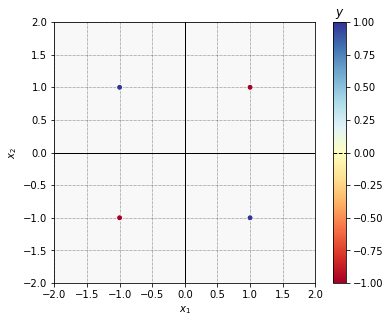

In [8]:
data.scatter(xs, ys)

Nu volgt het lastige stuk waarin we ons neurale netwerk functioneel gaan maken. We zullen het neurale netwerk enerzijds moeten leren om in de *forward-propagation* fase uit gegeven attributen aan de invoerzijde een predictie af te leiden aan de uitvoerzijde, en om anderzijds in de *back-propagation* fase voor een bepaalde predictie aan de uitvoerzijde een loss te berekenen en met de gradiënten hiervan terugwerkend naar de invoerzijde de biases en gewichten bij te werken.

### <a id='Forward_propagation'>Forward-propagation</a>

We zullen voor de forward-propagation gebruik maken van de `__call__()` methoden van de child-classes. Deze zorgen ervoor dat een object kan worden aangeroepen alsof het zelf een functie is. De `__call__()` methode kan voor de parent-class `Layer()` niet zinvol geïmplementeerd worden omdat elk type laag een andere operatie toepast op diens invoerwaarden. Omdat deze daarentegen wel door elke child-class gedefinieerd dient te worden, is dit een voorbeeld van een *abstracte* methode. We implementeren deze in de parent-class `Layer()` door slechts een foutmelding te genereren.

```python
    def __call__(self, xs):
        raise NotImplementedError('Abstract __call__ method')
```

Hieronder zie je de syntax waarmee een laag nu als een functie kan worden aangeroepen, zij het dat je een foutmelding zal krijgen omdat deze functie voor de `Layer()` class abstract is.

In [9]:
try:
    my_layer = model.Layer(5)
    ys = my_layer(xs)
except NotImplementedError:
    print('Alleen child-layers kunnen worden aangeroepen als een functie!')

Alleen child-layers kunnen worden aangeroepen als een functie!


We implementeren eerst de methoden die zorgen voor predictie. Dit kan recursief geïmplementeerd worden, waarbij elke laag de volgende laag aanroept totdat de recursie beëindigd wordt door de laatste laag.

* De `InputLayer()` ontvangt een (geneste) lijst instances `xs` van de gebruiker en kan deze onveranderd doorgeven aan de eerstvolgende verborgen laag door deze aan te roepen als `self.next(xs)`. De predictie die door die volgende layer wordt geretourneerd kan weer rechtstreeks terug naar de gebruiker. De `__call__()` methode is hierbij slechts een soort "doorgeefluik". Voeg voor het gebruiksgemak ook een methode met de naam `predict()` toe die een eenvoudige wrapper is om de `__call__()` methode van de `InputLayer()` zelf.

```python
    def __call__(self, xs):
        return self.next(xs)

    def predict(self, xs):
        yhats = self(xs)
        return yhats
```

* De `DenseLayer()` krijgt invoer binnen van een vorige laag, berekent hieruit middels lineaire combinatie voor elke instance en elk neuron een pre-activatiewaarde $a_{no} = b_o + \sum_i w_{oi} \cdot x_{ni}$ (waarbij de index $n$ loopt over de instances, $o$ over de `outputs`, en $i$ over de `inputs`), en geeft die uitkomsten door aan de volgende laag. De volgende laag gaat hier vervolgens mee verder rekenen en retourneert tenslotte voorspellingen die de `DenseLayer()` kan gebruiken als return value. Vul het onderstaande code-skelet aan.

```python
    def __call__(self, xs):
        aa = []   # Uitvoerwaarden voor alle instances xs
        for x in xs:
            a = []   # Uitvoerwaarde voor één instance x
            for o in range(self.outputs):
                # Bereken voor elk neuron o uit de lijst invoerwaarden x de uitvoerwaarde
                ...
                a.append(...)
            aa.append(a)
        yhats = self.next(...)
        return yhats
```

<div class="alert alert-info">**Opmerking:**<br />Hierboven worden `for`-`append()`-loops gesuggereerd om de uitvoeren $\boldsymbol{a}$ van de laag te berekenen, maar deze opzet leent zich ook uitstekend voor efficiëntere list comprehensions.</div>

* De `ActivationLayer()` maakt van elke pre-activatiewaarde een post-activatiewaarde door middel van de activatiefunctie $h_{no} = \varphi(a_{no})$, en geeft die door aan de volgende laag. Pas weer het code-skelet aan.

```python
    def __call__(self, xs):
        hh = []   # Uitvoerwaarden voor alle instances xs
        for x in xs:
            h = []   # Uitvoerwaarde voor één instance x
            for o in range(self.outputs):
                # Bereken voor elk neuron o uit de lijst invoerwaarden x de uitvoerwaarde
                ...
                h.append(...)
            hh.append(h)
        yhats = self.next(...)
        return yhats
```

* Een `LossLayer()` tenslotte krijgt diens invoer binnen uit de uitvoerlaag van het model, dus dat vormt reeds de voorspellingen $\boldsymbol{\hat{y}}$. De `LossLayer()` kan daardoor rechtstreeks de invoer retourneren als voorspelling. Je mag ervan uitgaan dat de laatste laag in het netwerk *altijd* een `LossLayer()` zal zijn. Vul de onderstaande code aan.

```python
    def __call__(self, xs):
        yhats = ...
        return yhats
```

Implementeer op deze manier de `__call__()` methoden voor alle child-classes. Je kan hierbij vermoedelijk onderdelen hergebruiken uit je uitwerking van het `Neuron()`.

De onderstaande code zet een neuraal netwerk op met meerdere lagen en stelt de biases en gewichten zo in dat de *XOR*-dataset correct gemodelleerd zou moeten worden.

In [10]:
my_network = model.InputLayer(2) + model.DenseLayer(2) + model.ActivationLayer(2, activation=model.sign) + model.DenseLayer(1) + model.LossLayer()
my_network[1].bias = [1.0, -1.0]
my_network[1].weights = [[1.0, 1.0], [1.0, 1.0]]
my_network[3].bias = [-1.0]
my_network[3].weights = [[1.0, -1.0]]

Verifieer hieronder dat alle instances exact juist voorspeld worden.

In [11]:
yhats = my_network.predict(xs)
DataFrame(xs, columns=['x1', 'x2']).assign(y=DataFrame(ys), ŷ=DataFrame(yhats))

,x1,x2,y,ŷ
0,-1.0,-1.0,-1.0,-1.0
1,1.0,-1.0,1.0,1.0
2,-1.0,1.0,1.0,1.0
3,1.0,1.0,-1.0,-1.0


Je ziet hieronder dat alle punten correct worden geclassificeerd. In dit geval loopt er een blauwe band diagonaal naar beneden; een andere correcte oplossing zou een rode band kunnen bevatten die diagonaal naar boven loopt. Probeer de bias en gewichten eens aan te passen om die andere oplossing te bereiken.

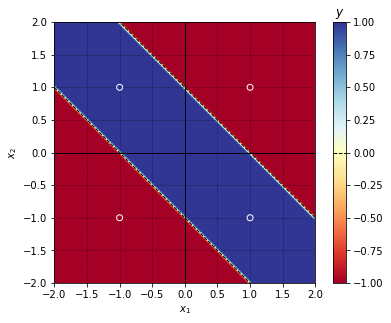

InputLayer(outputs=2, name='InputLayer_2') + DenseLayer(outputs=2, name='DenseLayer_3') + ActivationLayer(outputs=2, name='ActivationLayer_2', activation=sign) + DenseLayer(outputs=1, name='DenseLayer_4') + LossLayer(name='LossLayer_2', loss=mean_squared_error)


In [12]:
data.scatter(xs, ys, model=my_network)
print(my_network)

### <a id='Losses'>Losses</a>

De `predict()` methode is nuttig om voorspellingen te genereren voor nieuwe testdata. Echter, voor bestaande trainingsdata weten we de gewenste uitkomsten al. Dan is het zinvol om ook de loss te kunnen berekenen om een idee te hebben hoe goed ons model is. Immers, hoe beter het voorspellingen, hoe lager de loss.

We zullen daartoe de bestaande `__call()__` methoden uitbreiden zodat ze niet alleen de predicties `yhats` maar ook de losses `ls` van alle instances retourneren. De losses bestaan uit een lijst met voor elke instance $n$ één getalwaarde $l_n = \sum_o \mathcal{L} \left( \hat{y}_{no}; y_{no} \right)$, waarbij $o$ loopt over alle outputs van de uitvoerlaag van het model. Deze zullen door de `LossLayer()` berekend moeten worden, aangezien deze de vorm van de loss-functie kent. Daarvoor moet de laag ook de correcte uitkomsten `ys` kennen.

Maak de `__call__()` methode van de `LossLayer()` zo dat je de correcte uitkomsten `ys` niet per se hoeft mee te geven als parameter:

* als de $\boldsymbol{y}$ *niet* worden meegegeven bereken je *alleen* de predicties $\boldsymbol{\hat{y}}$;

* als de $\boldsymbol{y}$ *wel* worden meegegeven bereken je daarnaast *ook* de losses $l$.

Je krijgt zoiets als hieronder.

```python
    def __call__(self, xs, ys=None):
        yhats = ...
        ls = None
        if ys is not None:
            ls = ...
        return yhats, ls
```

De andere lagen hoeven het resultaat alleen maar door te geven van de volgende naar de vorige laag. Pas de andere child-classes aan zodat ze dat doen. Ook voor hen is het argument `ys` optioneel.

Tenslotte voegen we een methode `evaluate()` toe aan onze `InputLayer()` class die de *gemiddelde* loss over alle instances bepaalt. Daarvoor kunnen we weer volstaan met een simpele wrapper methode naar de gebruiker toe. In deze methode zijn de `ys` *niet* optioneel.

```python
    def evaluate(self, xs, ys):
        _, ls = self(xs, ys)
        lmean = sum(ls) / len(ls)
        return lmean
```

<div class="alert alert-info">**Opmerking:**<br />De `predict()` methode zal ietwat aangepast moeten worden om om te gaan met het feit dat nu ook een resultaat voor de losses wordt geretourneerd, hoewel dat daar niet daadwerkelijk gebruikt wordt.</div>

We testen de code hieronder. Als het goed is kun je nu zien dat in het voorgaande voorbeeld met de *XOR*-dataset inderdaad alle punten juist geclassificeerd werden: de loss is voor alle instances gelijk aan de laagst mogelijke waarde, dat wil zeggen nul.

In [13]:
lmean = my_network.evaluate(xs, ys)
print(f'De gemiddelde loss is gelijk aan {lmean:.3f}.')

TypeError: unsupported operand type(s) for -: 'list' and 'list'

### <a id='Back_propagation'>Back-propagation</a>

Hierboven hebben we zelf de biases en gewichten ingesteld om te zorgen dat het model de *XOR*-dataset kon beschrijven. Voor algemene datasets is dat meestal niet zo eenvoudig natuurlijk. Om op een systematischere manier algemene oplossingen te vinden voor de modelparameters in een multi-layer perceptron zullen we opnieuw de optimalisatie-methode gebaseerd op *gradiënt descent* moeten toepassen.

De algemene vorm van de update-regel luidde $b \leftarrow b - \alpha \cdot \frac{\partial l}{\partial b}$ en $w\leftarrow w-\alpha\cdot\frac{\partial l}{\partial w}$. In dit geval hebben we het echter over de *gemiddelde* loss over alle $N_n$ instances in `xs`. Dit leidt daarom tot de volgende update-regel die *per instance* kan worden toegepast:

$$
\left\{ \begin{array}{c}
b_o \leftarrow b_o - \frac{\alpha}{N_n} \cdot \frac{\partial l_n}{\partial b_o}\\
w_{oi}\leftarrow w_{oi}-\frac{\alpha}{N_n}\cdot\frac{\partial l_n}{\partial w_{oi}}
\end{array}\right.
$$

De indices lopen weer over de inputs ($i$), de outputs ($o$), en de instances ($n$). Om deze formule toe te kunnen passen dienen we voor de bias en gewichten van elk neuron in elke `DenseLayer()` te bepalen hoe de loss van een instance $l_n$ verandert als die parameters $b_o$ en $w_{oi}$ gewijzigd worden.

We beginnen te kijken hoe de loss afhangt van de *input* van elke layer. Oftewel, als we de invoer `xs` van een laag een klein beetje zouden kunnen verhogen of verlagen, hoe verandert dan de loss van het model voor de huidige instance? In formulevorm, hoe groot is $\frac{\partial l_n}{\partial x_{ni}}$? We zullen hierbij terugwerken van de losslaag richting de invoerlaag. Bestudeer sectie *3.3. Back-propagation* van de Syllabus zodat je weet hoe dit proces in zijn werk gaat.

Voor de losslaag zelf kan de afgeleide van de loss naar diens invoer $\frac{\partial l_n}{\partial x_{ni}}$ numeriek worden bepaald door de functie `derivative()` toe te passen op de loss-functie. Immers, voor de losslaag is de invoer $\boldsymbol{x}$ gelijk aan de voorspelling $\boldsymbol{\hat{y}}$, waardoor $\frac{\partial l_n}{\partial x_{ni}} = \frac{\partial l_n}{\partial \hat{y}_{ni}} =\frac{\partial}{\partial \hat{y}_{ni}} \mathcal{L}(\hat{y}_{ni}; y_{ni}) = \mathcal{L}'(\hat{y}_{ni}; y_{ni})$.

We breiden de definitie van de `__call__()` methode van de `LossLayer()` nog een (laatste) maal uit zodat deze naast de predicties en losses ook de gradiënten van de loss $\boldsymbol{\nabla}_\boldsymbol{x} l_n$ als retourwaarde `gs` geeft. Omdat we de gradiënten alleen nodig hebben als we het model trainen, en we hierbij een learning rate $\alpha$ zullen moeten specificeren, spreken we af dat de gradiënten alleen berekend hoeven te worden als een parameter `alpha` is meegegeven aan de functie. De code komt er dan ongeveer als volgt uit te zien:

```python
    def __call__(self, xs, ys=None, alpha=None):
        yhats = ...
        ls = None
        gs = None
        if ys is not None:
            ls = ...
            if alpha is not None:
                gs = ...
        return yhats, ls, gs
```

Voor de `ActivationLayer()` en de `DenseLayer()` geldt hierna dat ze berekende gradiënten binnenkrijgen van de volgende laag. In tegenstelling tot de losses `ls` kunnen de gradiënten `gs` helaas niet gewoon worden doorgegeven.

* Als de `ActivationLayer()` een gradiënt binnenkrijgt van de volgende laag gelijk aan $\boldsymbol{q}$, dan is dit de gradiënt van de loss naar de invoer van de volgende laag, oftewel naar de uitvoer van de huidige laag. De laag krijgt dus een lijst met waarden $q_{ni} = \frac{\partial l_n}{\partial h_{ni}}$ binnen (waarbij $\boldsymbol{h}$ de uitvoerwaarden van de activatie-laag zijn). De activatie-laag dient hieruit de gradiënt van de loss naar diens inputs $g_{ni} = \frac{\partial l_n}{\partial x_{ni}}$ te berekenen. Hiervoor kan worden gesteld dat $g_{ni} = \frac{\partial h_{ni}}{\partial x_{ni}} \cdot q_{ni}$. Omdat $h_{ni} = \varphi(x_{ni})$ is de afgeleide $\frac{\partial h_{ni}}{\partial x_{ni}}$ precies gelijk aan de helling van de activatiefunctie ter plekke van de invoer $x_{ni}$. We vinden de formule

$$
g_{ni} = \varphi'(x_{ni}) \cdot q_{ni}
$$

* Ook de `DenseLayer()` krijgt een lijst met gradiënten $q_{no} = \frac{\partial l_n}{\partial a_{no}}$ binnen van de volgende laag en dient hieruit de gradiënt van de loss naar de inputs $g_{ni} = \frac{\partial l_n}{\partial x_{ni}}$ te berekenen. In een fully-connected laag geldt $g_{ni} = \sum_o \frac{\partial a_{no}}{\partial x_{ni}} \cdot q_{no}$. Omdat $a_{no} = b_o + \sum_i w_{oi} \cdot x_{ni}$, is de afgeleide $\frac{\partial a_{no}}{\partial x_{ni}}$ precies gelijk aan het gewicht $w_{oi}$. Dit leidt tot

$$
g_{ni} = \sum_o w_{oi} \cdot q_{no}
$$

We kennen nu de gradiënten van de loss naar de in- en uitvoerwaarden van alle neurale lagen. De laatste stap is hieruit de gradiënten van de loss naar de instelbare netwerkparameters af te leiden. Deze zijn nodig om in de `DenseLayer()` de biases en gewichten bij te werken. Voor deze laag geldt dat er een pre-activatiewaarde wordt berekend volgens de formule $a_{no} = b_o + \sum_i w_{oi} \cdot x_{ni}$:

- De gradiënt naar een bias $b_o$ kan worden geschreven als $\frac{\partial l_n}{\partial b_o} = \frac{\partial l_n}{\partial a_{no}}\cdot\frac{\partial a_{no}}{\partial b_o}$. Hierin is $\frac{\partial l_n}{\partial a_{no}}$ inmiddels berekend (zie hierboven) en is $\frac{\partial a_{no}}{\partial b_o}=1$.

- De gradiënt naar een gewicht $w_{oi}$ kan worden geschreven als $\frac{\partial l_n}{\partial w_{oi}} = \frac{\partial l_n}{\partial a_{no}}\cdot\frac{\partial a_{no}}{\partial w_{oi}}$. Hierin is $\frac{\partial l_n}{\partial a_{no}}$ weer bekend, en de afgeleide $\frac{\partial a_{no}}{\partial w_{oi}}=x_{ni}$, net als in het vorige hoofdstuk voor het single-layer perceptron.

Kortom, zodra de gradiënten via back-propagation zijn doorgerekend, kunnen de afgeleiden van de loss naar de bias en gewichten hiermee ook worden bepaald. Hierop wordt tenslotte stochastic gradient descent toegepast. Alleen de `DenseLayer()` dient hierbij de update-regel toe te passen om diens parameters bij te werken. Zoals eerder gezegd luidt de update-regel hiervoor:

$$
\left\{ \begin{array}{c}
b_o \leftarrow b_o - \frac{\alpha}{N_n} \cdot \frac{\partial l_n}{\partial b_o}\\
w_{oi}\leftarrow w_{oi}-\frac{\alpha}{N_n}\cdot\frac{\partial l_n}{\partial w_{oi}}
\end{array}\right.
$$

Ook hier voegen we weer een eenvoudige wrapper methode toe aan de `InputLayer()` class. Dit is precies de `partial_fit()` functie die we ook kennen uit vorige hoofdstukken. Specificeer zelf weer een geschikte default waarde voor de learning rate $\alpha$.

```python
    def partial_fit(self, xs, ys, alpha=...):
        self(xs, ys, alpha)
```

Voeg tenslotte ook de `fit()` functie weer toe die een aantal epochs traint; deze code zul je waarschijnlijk identiek uit de vorige les kunnen overnemen.

Laten we dit multi-layer perceptron model eens gebruiken om het *XOR*-probleem te fitten. Eerst definiëren we een wat uitgebreidere dataset waaraan enige ruis is toegevoegd.

In [ ]:
xs, ys = data.xorproblem(num=200, noise=0.8)
data.scatter(xs, ys)

Dit keer kunnen we geen signum-functie gebruiken als activatie-functie omdat deze geen geschikte afgeleide heeft. Daarom passen we het model een beetje aan en kiezen we voor de afgevlakte versie in de vorm van de $\tanh$-functie, zoals we ook bij logistische regressie deden. We stoppen ook wat meer parallelle neuronen in de verborgen laag om het model krachtiger te maken zodat het een grotere kans heeft om te convergeren naar een bruikbare oplossing.

In [ ]:
my_network = model.InputLayer(2, name='Input')
my_network.add(model.DenseLayer(5, name='Dense'))
my_network.add(model.ActivationLayer(5, activation=model.tanh, name='Activation'))
my_network.add(model.DenseLayer(1, name='Output'))
my_network.add(model.LossLayer(name='Loss'))
my_network.fit(xs, ys, alpha=0.2, epochs=250)
data.scatter(xs, ys, model=my_network)
print(my_network)
print(f'- Loss: {my_network.evaluate(xs, ys)}')

Zijn de modellen die je krijgt als je de fit meerdere keren opnieuw berekent vergelijkbaar van vorm?

We kijken ook naar de voorspellingen voor de eerste instances. Merk op dat $\hat{y}$ nu niet altijd tussen $-1$ en $+1$ in ligt, zoals bij logistische regressie het geval was. Het model dat we nu hebben opgezet behandelt dit *XOR*-probleem als (niet-lineaire) regressie.

In [ ]:
yhats = my_network.predict(xs)
DataFrame(xs, columns=['x1', 'x2']).assign(y=DataFrame(ys), ŷ=DataFrame(yhats)).head()

<div class="alert alert-success">**Gefeliciteerd!**<br />Je hebt nu een krachtig neuraal netwerk geïmplementeerd dat zelf willekeurige niet-lineaire problemen kan leren oplossen.</div>

Ter vergelijking passen we hieronder een neuraal netwerk op deze dataset toe uit de deep-learning module [keras](https://keras.io/getting-started/sequential-model-guide/) van Google's [tensorflow](https://en.wikipedia.org/wiki/TensorFlow) bibliotheek. Omdat dit model de data in de vorm van een numpy array verwacht (vergelijkbaar met een matrix array in de programmeertaal *R*) converteren we eerst de data naar dit formaat.

In [ ]:
krs_xs, krs_ys = array(xs), array(ys)

De syntax van `tensorflow.keras` is zeer vergelijkbaar met die van je eigen model. Een verschil is dat het type model eerst expliciet als een *sequentieel* model dient te worden gedefinieerd. Daarnaast wordt de loss functie niet in een aparte uitvoerlaag toegevoegd maar middels een speciale compilatie-stap, en daarbij moet tevens de optimalisatie-methode en diens learning rate worden ingesteld (hier: *stochastic gradient descent*, `SGD()`). De weergave van het model in tekstvorm ziet er ook ietsjes anders uit. Ondanks die kleine verschillen zou de onderstaande code inmiddels begrijpelijk moeten zijn.

In [ ]:
krs_network = keras.models.Sequential()
krs_network.add(keras.layers.InputLayer(input_shape=(2, ), name='Input'))
krs_network.add(keras.layers.Dense(5, name='Dense'))
krs_network.add(keras.layers.Activation(activation=keras.activations.tanh, name='Activation'))
krs_network.add(keras.layers.Dense(1, name='Output'))
krs_network.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.SGD(learning_rate=0.2))
krs_network.fit(krs_xs, krs_ys, verbose=0, epochs=250)
data.scatter(krs_xs, krs_ys, model=krs_network)
krs_network.summary()
print(f'- Loss: {krs_network.evaluate(xs, ys, verbose=0)}')

De opzet van het neurale netwerk is identiek gekozen aan je eerdere eigen model: de diepte en breedte van het model zijn hetzelfde (dat wil zeggen, het aantal lagen en het aantal neuronen per laag), en dezelfde activatie- en loss-functies zijn gekozen. Ziet de oplossing er daardoor ongeveer hetzelfde uit als voor je eigen model, en is de kwaliteit van de voorspellingen zoals gemeten met de gemiddelde loss vergelijkbaar? Waar zouden eventuele verschillen door kunnen komen, denk je?

<div class="alert alert-info">**Opmerking:**<br />Een soortgelijke dataset als deze met bijbehorend model is ook [online](http://playground.tensorflow.org/#activation=tanh&dataset=xor&networkShape=5) te vinden om interactief mee te experimenteren.</div>

***

<small>&copy; 2021, Dave R.M. Langers, [d.r.m.langers@pl.hanze.nl](mailto:d.r.m.langers@pl.hanze.nl)</small>